In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline



#Este codigo foi para remover o warning 
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)


In [13]:
df = pd.read_csv('weather_day.csv')
df = df[['dteday', 'cnt', 'temp']].dropna()

df['dteday'] = pd.to_datetime(df['dteday'])
df = df.set_index('dteday')

daily_df = df.resample('D').mean()
d_df = daily_df.reset_index().dropna()

d_df['date_index'] = d_df['dteday']
d_df['date_index'] = pd.to_datetime(d_df['date_index'])
d_df = d_df.set_index('date_index')

In [14]:
d_df.head()

,dteday,cnt,temp
date_index,,,
2011-01-01,2011-01-01,985.0,0.344167
2011-01-02,2011-01-02,801.0,0.363478
2011-01-03,2011-01-03,1349.0,0.196364
2011-01-04,2011-01-04,1562.0,0.200000
2011-01-05,2011-01-05,1600.0,0.226957


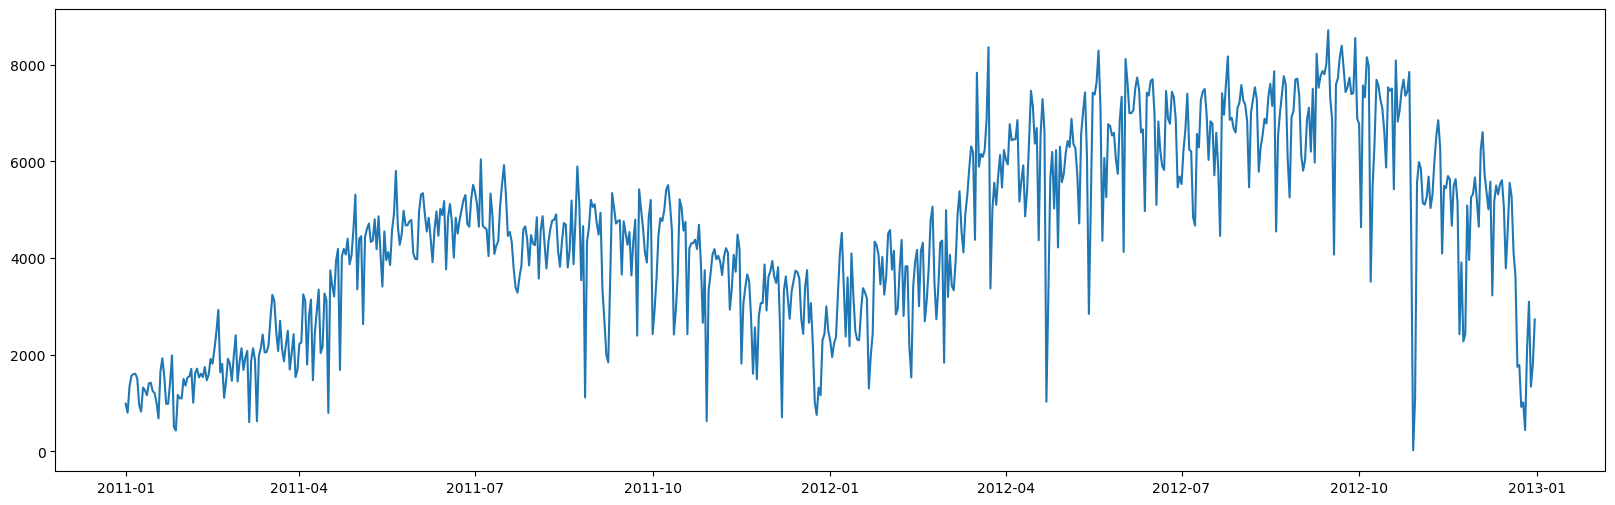

In [15]:
d_df.columns = ['ds', 'y', 'temp']

fig = plt.figure(facecolor='w', figsize=(20, 6))
plt.plot(d_df.ds, d_df.y)

In [16]:
t = 13
min_t = -8
max_t = 39
n_t = (t - min_t)/(max_t - min_t)
print(n_t)

future_range = pd.date_range('2013-01-01', periods=10, freq='D')
future_temp_df = pd.DataFrame({ 'future_date': future_range, 'future_temp' : 0})

future_temp_df['future_date'] = pd.to_datetime(future_temp_df['future_date'])
future_temp_df = future_temp_df.set_index('future_date')

future_temp_df.at['2013-01-01', 'future_temp'] = 0.319148
future_temp_df.at['2013-01-02', 'future_temp'] = 0.255319
future_temp_df.at['2013-01-03', 'future_temp'] = 0.234042
future_temp_df.at['2013-01-04', 'future_temp'] = 0.319148
future_temp_df.at['2013-01-05', 'future_temp'] = 0.340425
future_temp_df.at['2013-01-06', 'future_temp'] = 0.404255
future_temp_df.at['2013-01-07', 'future_temp'] = 0.361702
future_temp_df.at['2013-01-08', 'future_temp'] = 0.404255
future_temp_df.at['2013-01-09', 'future_temp'] = 0.425531
future_temp_df.at['2013-01-10', 'future_temp'] = 0.446808

future_temp_df.tail(10)

0.44680851063829785


,future_temp
future_date,
2013-01-01,0.319148
2013-01-02,0.255319
2013-01-03,0.234042
2013-01-04,0.319148
2013-01-05,0.340425
2013-01-06,0.404255
2013-01-07,0.361702
2013-01-08,0.404255
2013-01-09,0.425531


In [17]:
def weather_temp(ds):
    date = (pd.to_datetime(ds)).date()
    
    if d_df[date:].empty:
        return future_temp_df[date:]['future_temp'].values[0]
    else:
        return (d_df[date:]['temp']).values[0]
    
    return 0

m = Prophet()
m.add_regressor('temp')
m.fit(d_df)

future = m.make_future_dataframe(periods=10)
future['temp'] = future['ds'].apply(weather_temp)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
726,2012-12-27,3741.558902,2541.184971,4917.589392
727,2012-12-28,3827.443666,2660.541469,5006.063383
728,2012-12-29,3822.210202,2546.443892,5042.336690
729,2012-12-30,3559.926545,2372.700035,4709.297219
730,2012-12-31,3522.376458,2357.175692,4732.258597
731,2013-01-01,4177.007770,3021.685542,5294.498479
732,2013-01-02,4027.925579,2901.346689,5190.262834
733,2013-01-03,4154.061523,2875.213411,5264.373042
734,2013-01-04,4686.012952,3471.442594,5929.953084
735,2013-01-05,4838.699813,3707.036094,5969.917034


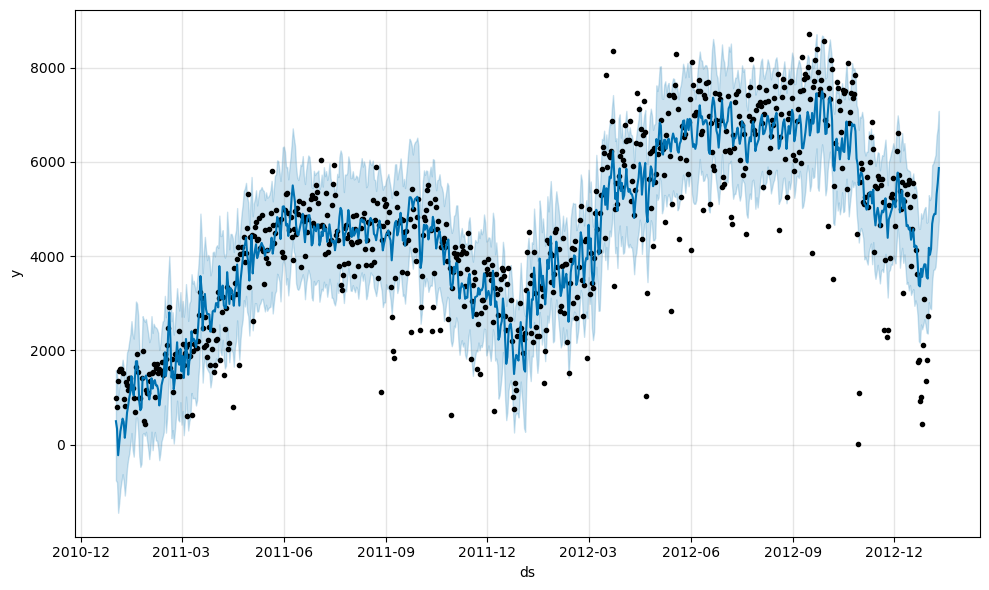

In [18]:
fig1 = m.plot(forecast)

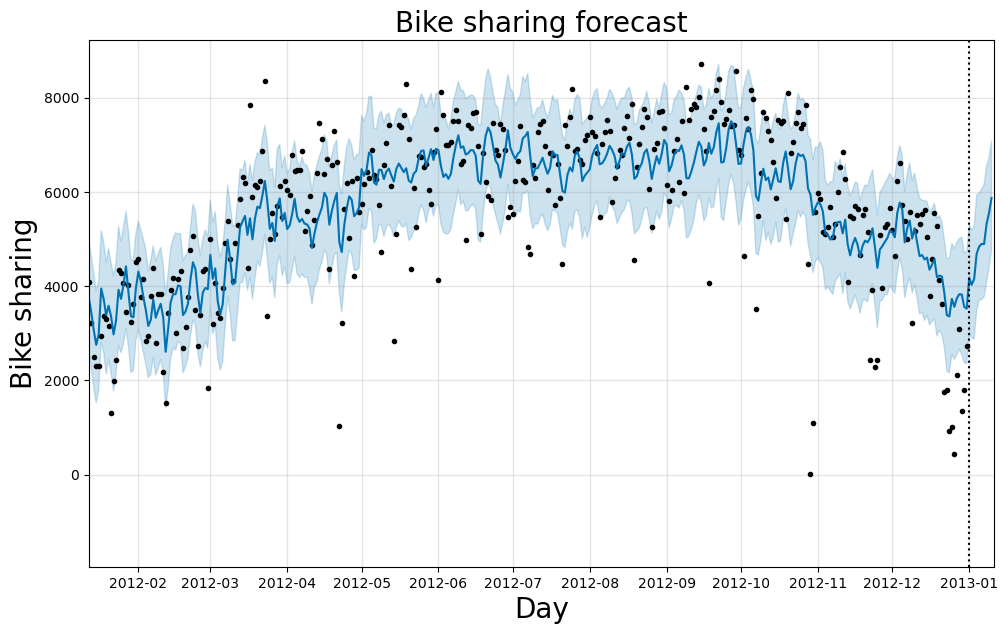

In [19]:
from datetime import datetime, timedelta

fig1 = m.plot(forecast)

#datenow = datetime.now()
datenow = datetime(2013, 1, 1)
dateend = datenow + timedelta(days=10)
datestart = dateend - timedelta(days=365)

plt.xlim([datestart, dateend])
plt.title("Bike sharing forecast", fontsize=20)
plt.xlabel("Day", fontsize=20)
plt.ylabel("Bike sharing", fontsize=20)
plt.axvline(datenow, color="k", linestyle=":")
plt.show()

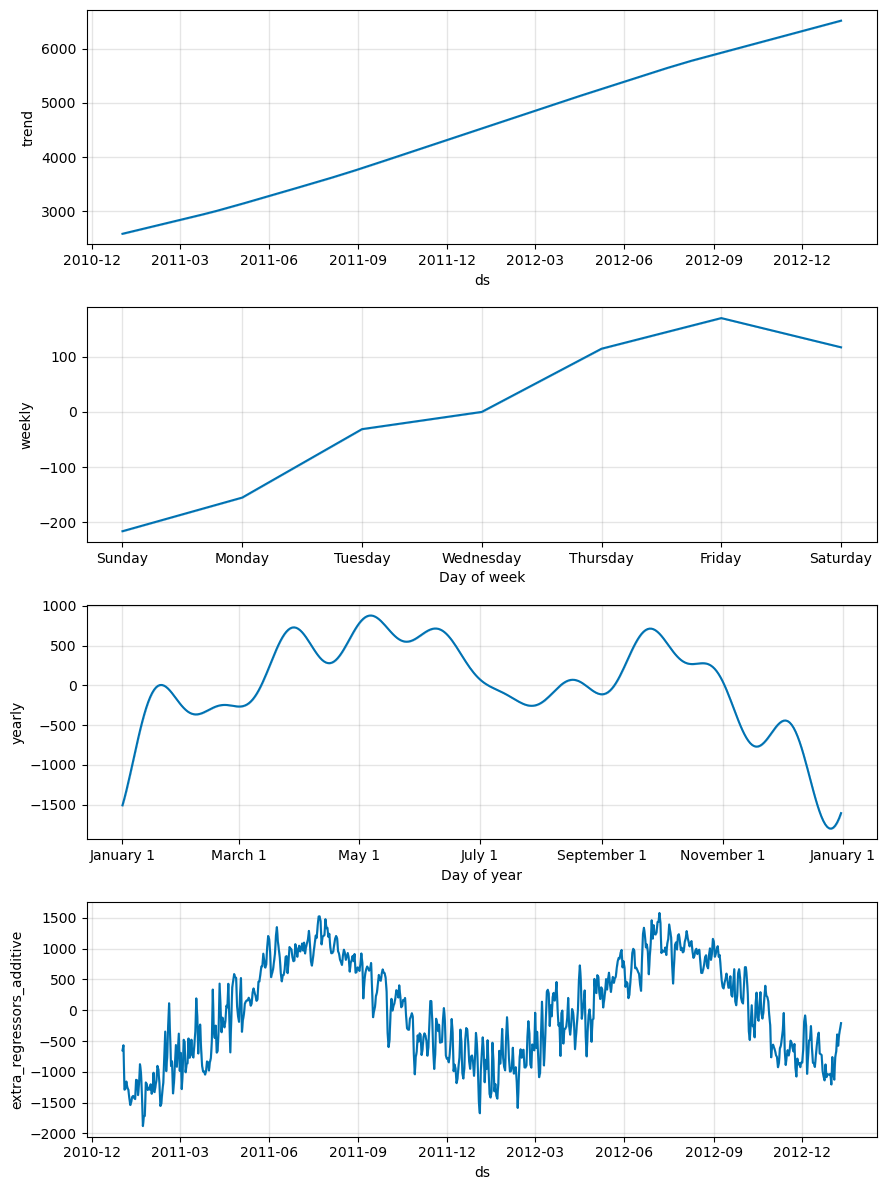

In [20]:
fig2 = m.plot_components(forecast)

In [21]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='30 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

  0%|          | 0/23 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.697515e+06,1302.887238,986.913329,0.249960,0.133305,0.190358,0.565217
1,4 days,1.525272e+06,1235.018877,926.181577,0.232854,0.127862,0.177215,0.623188
2,5 days,1.028322e+06,1014.061947,789.121764,0.155795,0.116597,0.148186,0.695652
3,6 days,9.050960e+05,951.365324,710.400884,0.147396,0.101695,0.137599,0.753623
4,7 days,9.156382e+05,956.889844,731.370185,0.158481,0.088974,0.145014,0.739130


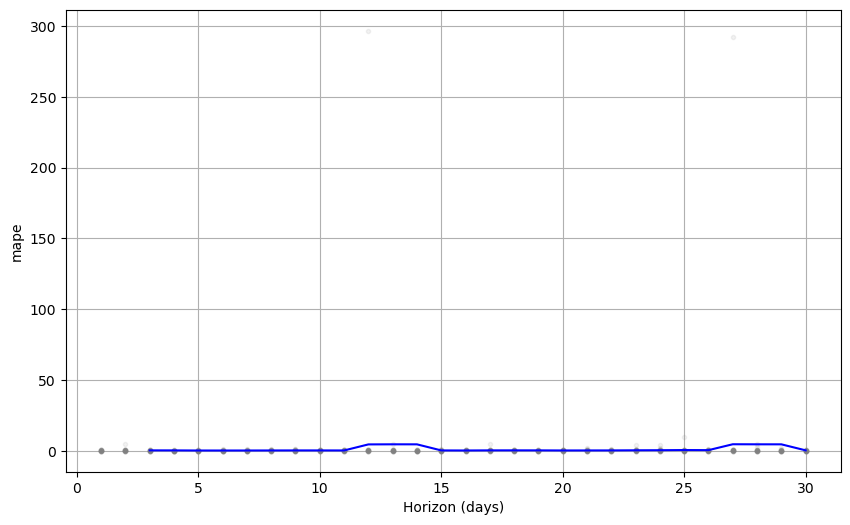

In [22]:
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape')